# <B> Anormaly Detection based on AutoEncoder </B>
* Container: codna_pytorch_p39

## AutoEncoder based anomaly detection

- **RaPP** - Novelty Detection with Reconstruction along Projection Pathway <br>
<p align="center">
    <img src="imgs/rapp-f1.png" width="1100" height="300" style="display: block; margin: 0 auto"/>
</p>
<p align="center">
    <img src="imgs/rapp-f2.png" width="1100" height="300" style="display: block; margin: 0 auto"/>
</p>

    * [Ppaer, ICLR 2020] https://openreview.net/attachment?id=HkgeGeBYDB&name=original_pdf
    * [Desc, KOREAN] [RaPP](https://makinarocks.github.io/rapp/)
    * [Supplement #1] [Autoencoder based Anomaly Detection](https://makinarocks.github.io/Autoencoder-based-anomaly-detection/)
    * [Supplement #2] [Reference code (github)](https://github.com/Aiden-Jeon/RaPP)

## AutoReload

In [1]:
%load_ext autoreload
%autoreload 2

## parameter store 설정

In [2]:
import boto3
from utils.ssm import parameter_store

In [3]:
strRegionName=boto3.Session().region_name
pm = parameter_store(strRegionName)
strPrefix = pm.get_params(key="PREFIX")

## pramamters for tasks

In [4]:
strAccountId = pm.get_params(key="-".join([strPrefix, "ACCOUNT-ID"]))
strBucketName = pm.get_params(key="-".join([strPrefix, "BUCKET"]))
strExecutionRole = pm.get_params(key="-".join([strPrefix, "SAGEMAKER-ROLE-ARN"]))
strS3DataPath = pm.get_params(key="-".join([strPrefix, "S3-DATA-PATH"]))

In [5]:
print (f"prefix: {strPrefix}")
print (f"account_id: {strAccountId}")
print (f"defaulut_bucket: {strBucketName}")
print (f"sagemaker_role: {strExecutionRole}")
print (f"s3_data_path: {strS3DataPath}")

prefix: ad-ts
account_id: 419974056037
defaulut_bucket: sm-anomaly-detection
sagemaker_role: arn:aws:iam::419974056037:role/service-role/AmazonSageMaker-ExecutionRole-20221206T163436
s3_data_path: s3://sm-anomaly-detection/data


## 1. Data manipulation and visualization

In [6]:
import os
import pandas as pd
from utils.util import plot_click_w_fault_and_res, plot_click_w_fault_res_ad, plot_click_w_ad_exp

* load data and derive features

In [7]:
clicks_1T = pd.read_csv(os.path.join(strS3DataPath, "clicks_1T.csv"), parse_dates=["timestamp"]).set_index("timestamp")
clicks_1T["residual"] = clicks_1T['click'] - clicks_1T['user'] 
clicks_1T["fault"] = pd.read_csv(os.path.join(strS3DataPath, "fault_label_1T.csv"), header=None).values[0] ## label
clicks_1T["time"] = [int(str(time).split(" ")[1].split(":")[0]) for time in clicks_1T.index] ## time variable

In [8]:
print (f'data shape: {clicks_1T.shape}')
print (f'timestamp min: {clicks_1T.index.min()}, max: {clicks_1T.index.max()}')

data shape: (12960, 6)
timestamp min: 2020-07-07 00:00:00, max: 2020-07-15 23:59:00


* visualization

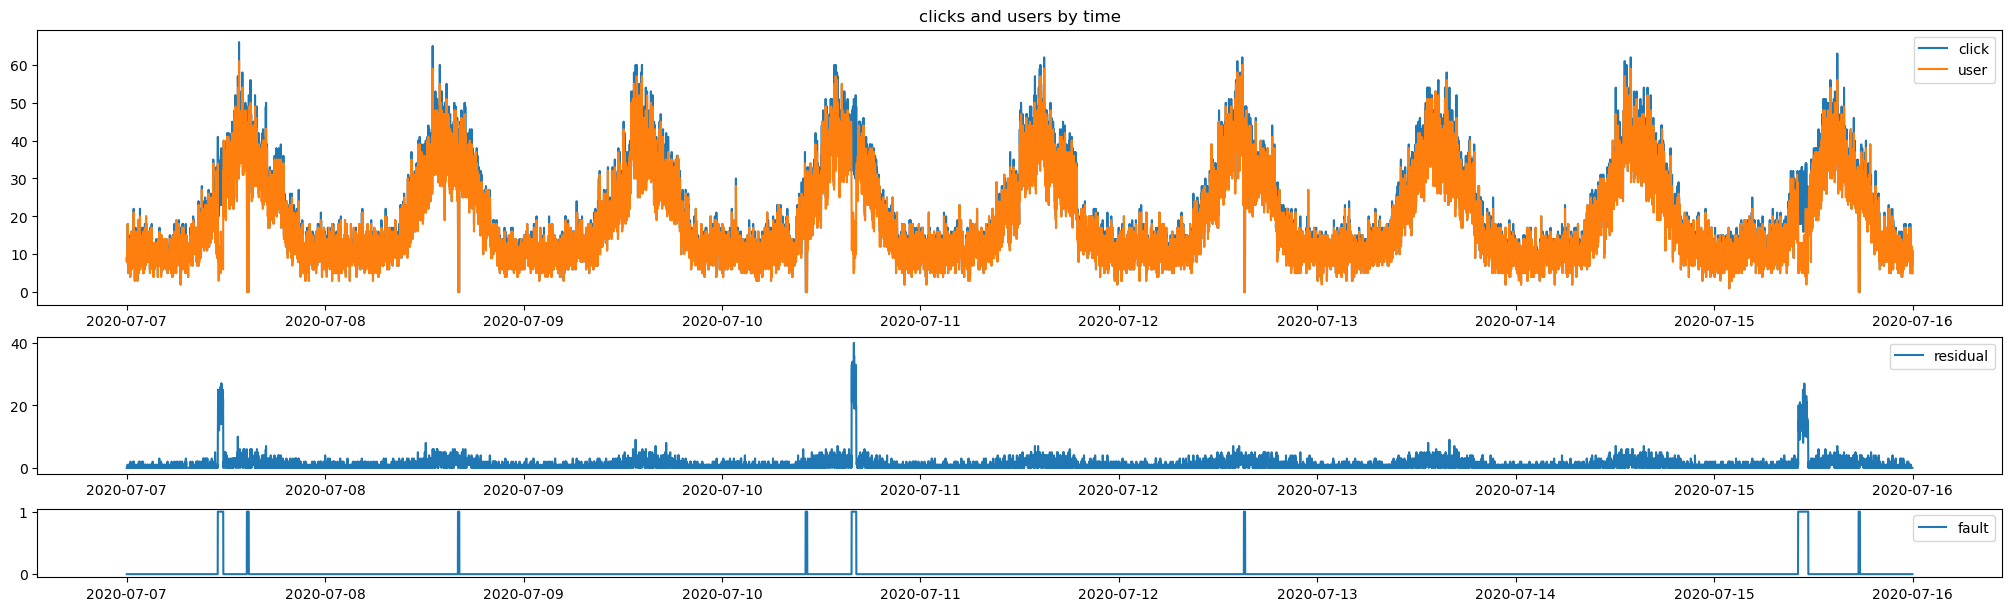

In [9]:
plot_click_w_fault_and_res(clicks_1T)

## 2. Preprocessing

* data split

In [10]:
pdData = clicks_1T[["time", "page", "user", "click", "residual", "fault"]]
print (f'Data shape: {pdData.shape}')
pdData.tail()

Data shape: (12960, 6)


,time,page,user,click,residual,fault
timestamp,,,,,,
2020-07-15 23:55:00,23,6,10,10,0,0
2020-07-15 23:56:00,23,5,12,12,0,0
2020-07-15 23:57:00,23,5,7,7,0,0
2020-07-15 23:58:00,23,6,11,11,0,0
2020-07-15 23:59:00,23,4,5,5,0,0


In [11]:
npData_x, npData_y = pdData[[strCol for strCol in pdData.columns if strCol != "fault"]].values, pdData["fault"].values.reshape(-1, 1)
npData_x, npData_time = npData_x[:, 1:], npData_x[:, 0].reshape(-1, 1)

npData_x.shape, npData_y.shape, npData_time.shape

((12960, 4), (12960, 1), (12960, 1))

In [12]:
npData_x, npData_y, npData_time

(array([[ 4,  9,  9,  0],
        [ 7,  8,  8,  0],
        [ 4,  9,  9,  0],
        ...,
        [ 5,  7,  7,  0],
        [ 6, 11, 11,  0],
        [ 4,  5,  5,  0]]),
 array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]),
 array([[ 0],
        [ 0],
        [ 0],
        ...,
        [23],
        [23],
        [23]]))

* StandardScaler
    * Standardize features by removing the mean and scaling to unit variance

In [13]:
import pickle
from sklearn.preprocessing import StandardScaler

In [14]:
scaler = StandardScaler()

In [15]:
scaler.fit(npData_x)

StandardScaler()

In [16]:
npDataScaled_x = scaler.transform(npData_x)

* dump scaler

In [17]:
with open(file="./dump/scaler.pkl", mode="wb") as f: pickle.dump(scaler, f)

In [18]:
#with open(file="./dump/scaler.pkl", mode="rb") as f: scaler=pickle.load(f)

* shingle

In [19]:
import numpy as np

In [20]:
def shingle(data, shingle_size=32):
    num_data, num_features = data.shape[0], data.shape[1]
    shingled_data = np.zeros((num_data-shingle_size+1, shingle_size*num_features))
    
    print (num_data, shingled_data.shape)
    
    for idx_feature in range(num_features):
        
        if idx_feature == 0:
            start, end = 0, shingle_size
        else:
            start = end
            end = start + shingle_size
                
        for n in range(num_data - shingle_size + 1):
            if n+shingle_size == num_data: shingled_data[n, start:end] = data[n:, idx_feature]    
            else: shingled_data[n, start:end] = data[n:(n+shingle_size), idx_feature]
                
    
    return shingled_data

In [21]:
nShingleSize=4
npDataShingle_x = shingle(npDataScaled_x, shingle_size=nShingleSize)
npDataShingle_time = shingle(npData_time, shingle_size=nShingleSize)[:, -1].reshape(-1, 1)
npDataShingle_y = shingle(npData_y, shingle_size=nShingleSize)[:, -1].reshape(-1, 1)
npDataShingle_x = np.concatenate([npDataShingle_time, npDataShingle_x], axis=1)

print (f'data_x_scaled_shingle: {npDataShingle_x.shape}')
print (f'data_y_shingle: {npDataShingle_y.shape}')
print (f'check label: {sum(npDataShingle_y == npData_y[nShingleSize-1:])}')
print (f'fault cnt, data_y_shingle: {sum(npDataShingle_y)}, train_y: {sum(npData_y[nShingleSize-1:])}')

12960 (12957, 16)
12960 (12957, 4)
12960 (12957, 4)
data_x_scaled_shingle: (12957, 17)
data_y_shingle: (12957, 1)
check label: [12957]
fault cnt, data_y_shingle: [203.], train_y: [203]


In [22]:
# shingle_size=4
# test_x_scaled_shingle = shingle(test_x_scaled, shingle_size=shingle_size)
# test_y_shingle = shingle(test_y, shingle_size=shingle_size)[:, -1].reshape(-1, 1)

# print (f'# features: {test_x_scaled.shape[1]}, shingle_size: {shingle_size}')
# print (f'test_x_scaled_shingle: {test_x_scaled_shingle.shape}')
# print (f'test_y_shingle: {test_y_shingle.shape}')
# print (f'check label: {sum(test_y_shingle == test_y[shingle_size-1:])}')
# print (f'fault cnt, train_y_shingle: {sum(test_y_shingle)}, train_y: {sum(test_y[shingle_size-1:])}')

## 3. AutoEncoder

In [23]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from sklearn.metrics import f1_score

* gpu setting

In [24]:
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"# DEVICE {i}: {torch.cuda.get_device_name(i)}")
        print("- Memory Usage:")
        print(f"  Allocated: {round(torch.cuda.memory_allocated(i)/1024**3,1)} GB")
        print(f"  Cached:    {round(torch.cuda.memory_reserved(i)/1024**3,1)} GB\n")
        
else:
    print("# GPU is not available")
    
# GPU 할당 변경하기
GPU_NUM = 0 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU

print ('# Current cuda device: ', torch.cuda.current_device()) # check

# DEVICE 0: Tesla V100-SXM2-16GB
- Memory Usage:
  Allocated: 0.0 GB
  Cached:    0.0 GB

# Current cuda device:  0


* parameters for training

In [25]:
nEpoch = 150
nBatchSize = 128
fLR = 1e-2

nFeaures = 4 # not include time
nShingleSize = nShingleSize
nEmbSize = 4

* custom dataset and data loader

In [26]:
class CustomDataset(Dataset):
    
    def __init__(self, x, y):
        
        self.x, self.y = x, y

    def __len__(self):
        
        return len(self.x)

    def __getitem__(self, idx):
        
        time = torch.tensor(self.x[idx, 0]).type(torch.int) 
        x = torch.tensor(self.x[idx, 1:]).type(torch.float32)
        y = torch.tensor(self.y[idx]).type(torch.int)
        
        return time, x, y

* define dataset

In [27]:
train_ds = CustomDataset(
    x=npDataShingle_x,
    y=npDataShingle_y
)

* define dataloader

In [28]:
train_loader = torch.utils.data.DataLoader(
    dataset = train_ds,
    batch_size = nBatchSize,
    shuffle = True,
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    dataset = train_ds,
    batch_size = nBatchSize,
    shuffle = False,
    pin_memory=True
)

* define network architecture

In [29]:
class AutoEncoder(nn.Module):

    def __init__(self, encoder, decoder, emb_size):
        
        super(AutoEncoder, self).__init__()
        
        self.emb = nn.Embedding(num_embeddings=24, embedding_dim=emb_size)
        self.encoder = encoder
        self.decoder = decoder

    def encode(self, x):
        # |x| = (batch_size, #c, w, h)
        z = self.encoder(x)
        return z.view(x.size(0), -1)

    def decode(self, z):
        # |z| = (batch_size, btl_size)
        y = self.decoder(z)
        return y

    def forward(self, time, x):
        t_emb = self.emb(time)
        x = torch.cat([t_emb, x], dim=1)
        
        z = self.encode(x)
        x_hat = self.decode(z)
        x_hat = x_hat
        return t_emb, x_hat.view(x.size(0), -1)


In [30]:
class FCLayer(nn.Module):
    
    def __init__(self, input_size, output_size=1, bias=True, last_act=True, bn=False, dropout_p=0):
        
        super().__init__()
        self.layer = nn.Linear(input_size, output_size, bias)
        self.bn = nn.BatchNorm1d(output_size) if bn else None
        self.dropout = nn.Dropout(dropout_p) if dropout_p else None
        if last_act: self.act = None
        else: self.act = nn.LeakyReLU(.2)
    
    def forward(self, x):
         
        y = self.act(self.layer(x)) if self.act else self.layer(x)
        y = self.bn(y) if self.bn else y
        y = self.dropout(y) if self.dropout else y

        return y

class FCModule(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=None, use_batch_norm=True, dropout_p=0):

        super().__init__()
        self.layer_list = []

        if use_batch_norm and dropout_p > 0:
            raise Exception("Either batch_norm or dropout is allowed, not both")

        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for idx, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            if idx < len(hidden_sizes):
                layer = FCLayer(
                    input_size=in_size,
                    output_size=out_size,
                    last_act=False,
                    bn=use_batch_norm,
                    dropout_p=dropout_p
                )
            else:
                layer = FCLayer(
                    input_size=in_size,
                    output_size=out_size,
                    last_act=True,
                )

            self.layer_list.append(layer)
        self.net = nn.Sequential(*self.layer_list)

    def forward(self, x):
        return self.net(x)


In [31]:
def get_model(input_dim, hidden_sizes, btl_size, emb_size):
    
    # args
    input_size = input_dim
    
    encoder = FCModule(
        input_size=input_size,
        output_size=btl_size,
        hidden_sizes=hidden_sizes, 
        use_batch_norm=True
    )
    
    decoder = FCModule(
        input_size=btl_size,
        output_size=input_size,
        hidden_sizes=list(reversed(hidden_sizes)),
        use_batch_norm=True,
    )

    model = AutoEncoder(
        encoder=encoder,
        decoder=decoder,
        emb_size=emb_size
    )

    return model

* define train class

In [32]:
class Trainer():
    
    def __init__(self, model, optimizer, train_loader, val_loader, scheduler, device, epoch):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.device = device
        self.epoch = epoch
        
        # Loss Function
        self.criterion = nn.L1Loss().to(self.device)
        self.anomaly_calculator = nn.L1Loss(reduction="none").to(self.device)        
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        
    def fit(self, ):
        
        self.model.to(self.device)
        best_score = 0
        for epoch in range(self.epoch):
            self.model.train()
            train_loss = []
            for time, x, y in self.train_loader:
        
                time, x = time.to(self.device), x.to(self.device)        
                
                self.optimizer.zero_grad()
                
                t_emb, _x = self.model(time, x)
                x = torch.cat([t_emb, x], dim=1)
                
                loss = self.criterion(x, _x)
                loss.backward()
                self.optimizer.step()

                train_loss.append(loss.item())

            
            if epoch % 10 == 0 :
                score = self.validation(self.model, 0.95)
                diff = self.cos(x, _x).cpu().tolist()
                print(f'Epoch : [{epoch}] Train loss : [{np.mean(train_loss)}], Train cos : [{np.mean(diff)}] Val cos : [{score}])')

            if self.scheduler is not None:
                self.scheduler.step(score)

            if best_score < score:
                best_score = score
                torch.save(model.module.state_dict(), './best_model.pth', _use_new_zipfile_serialization=False)
                
        return self.model
    
    def validation(self, eval_model, thr):
        
        eval_model.eval()
        with torch.no_grad():
            for time, x, y in self.val_loader:
                time, x, y= time.to(self.device), x.to(self.device), y.to(self.device)
                t_emb, _x = self.model(time, x)
                x = torch.cat([t_emb, x], dim=1)
                
                anomal_score = self.anomaly_calculator(x, _x)
                diff = self.cos(x, _x).cpu().tolist()
                
        return np.mean(diff)
        
    def prediction(self, model, test_loader, num_features, shingle_size, feature_name, emb_size):
        model.to(self.device)
        model.eval()
                
        anomal_scores = []
        stacked = []
        with torch.no_grad():
            for time, x, y in test_loader:
                
                time, x, y= time.to(self.device), x.to(self.device), y.to(self.device)
                t_emb, _x = model(time, x)
                x = torch.cat([t_emb, x], dim=1)

                anomal_score = self.anomaly_calculator(x[:, emb_size:], _x[:, emb_size:]) # without time
                anomal_score_sap = 0
                for layer in model.module.encoder.layer_list:
                    x, _x = layer(x), layer(_x)
                    diffs = self.anomaly_calculator(x, _x)
                    anomal_score_sap += (diffs).mean(dim=1)
                
                for record, fault, sap in zip(anomal_score.cpu().numpy(), y.cpu().numpy(), anomal_score_sap.cpu().numpy()):
                    dicScore = {"fault": fault[0], "ANOMALY_SCORE_SAP": sap}
                    for cnt, idx in enumerate(range(0, shingle_size*num_features, shingle_size)):
                        start = idx
                        end = start + shingle_size
                        dicScore[feature_name[cnt] + "_ATTRIBUTION_SCORE"] = np.mean(record[start:end])
                    
                    total_socre = 0
                    for k, v in dicScore.items():
                        if k not in ["fault", "ANOMALY_SCORE_SAP"]: total_socre += v
                    dicScore["ANOMALY_SCORE"] = total_socre
                    #dicScore["ANOMALY_SCORE_SAP"] = dicScore["ANOMALY_SCORE_SAP"] + total_socre
                    anomal_scores.append(dicScore)
                    
        return pd.DataFrame(anomal_scores)


In [33]:
model = nn.DataParallel(
    get_model(
        input_dim=nFeaures*nShingleSize + nEmbSize,
        hidden_sizes=[64, 48],
        btl_size=32,
        emb_size=nEmbSize
    )
)

optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=fLR
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='max',
    factor=0.5,
    patience=10,
    threshold_mode='abs',
    min_lr=1e-8,
    verbose=True
)

In [34]:
trainer = Trainer(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=test_loader,
    scheduler=scheduler,
    device=device,
    epoch=nEpoch
)

In [35]:
model

DataParallel(
  (module): AutoEncoder(
    (emb): Embedding(24, 4)
    (encoder): FCModule(
      (net): Sequential(
        (0): FCLayer(
          (layer): Linear(in_features=20, out_features=64, bias=True)
          (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): LeakyReLU(negative_slope=0.2)
        )
        (1): FCLayer(
          (layer): Linear(in_features=64, out_features=48, bias=True)
          (bn): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): LeakyReLU(negative_slope=0.2)
        )
        (2): FCLayer(
          (layer): Linear(in_features=48, out_features=32, bias=True)
        )
      )
    )
    (decoder): FCModule(
      (net): Sequential(
        (0): FCLayer(
          (layer): Linear(in_features=32, out_features=48, bias=True)
          (bn): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): LeakyReLU(negative_slo

In [36]:
model_trained = trainer.fit()

Epoch : [0] Train loss : [0.2552652432053697], Train cos : [0.9110834495774631] Val cos : [0.9316854456375385])
Epoch : [10] Train loss : [0.09558164346597943], Train cos : [0.9758620693765837] Val cos : [0.9935111855638439])
Epoch : [20] Train loss : [0.09180554185135692], Train cos : [0.9838227855748144] Val cos : [0.9920236201121889])
Epoch 00022: reducing learning rate of group 0 to 5.0000e-03.
Epoch : [30] Train loss : [0.07721390633606444], Train cos : [0.9828628527707067] Val cos : [0.9963253818709275])
Epoch : [40] Train loss : [0.08222899480047179], Train cos : [0.9646907304895336] Val cos : [0.9975088731995945])
Epoch : [50] Train loss : [0.07723013585542932], Train cos : [0.9667475799034382] Val cos : [0.9984599249116306])
Epoch : [60] Train loss : [0.07750353509304571], Train cos : [0.9859085309094396] Val cos : [0.9979503833014389])
Epoch 00062: reducing learning rate of group 0 to 2.5000e-03.
Epoch : [70] Train loss : [0.0730757879312424], Train cos : [0.9852057900922052]

In [37]:
feature_name = ["URLS", "USERS", "CLICKS", "RESIDUALS"]
pdScores = trainer.prediction(model_trained, test_loader, nFeaures, nShingleSize, feature_name, nEmbSize)

In [40]:
pdScores.index = pdData.iloc[nShingleSize-1:, :].index
pdScores = pd.concat([pdScores, pdData.iloc[nShingleSize-1:, :].drop(columns='fault')], axis=1).rename(columns={"page":"url"})

In [41]:
pdScores

,fault,ANOMALY_SCORE_SAP,URLS_ATTRIBUTION_SCORE,USERS_ATTRIBUTION_SCORE,CLICKS_ATTRIBUTION_SCORE,RESIDUALS_ATTRIBUTION_SCORE,ANOMALY_SCORE,time,url,user,click,residual
timestamp,,,,,,,,,,,,
2020-07-07 00:03:00,0,0.244516,0.060024,0.058175,0.059768,0.018581,0.196548,0,6,11,11,0
2020-07-07 00:04:00,0,0.241181,0.054663,0.056879,0.058679,0.021018,0.191239,0,4,9,9,0
2020-07-07 00:05:00,0,0.246397,0.063718,0.058654,0.060299,0.016224,0.198895,0,5,9,9,0
2020-07-07 00:06:00,0,0.216005,0.055325,0.051877,0.053132,0.018410,0.178744,0,6,14,15,1
2020-07-07 00:07:00,0,0.210998,0.058728,0.045170,0.048222,0.021718,0.173838,0,7,18,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-15 23:55:00,0,0.229190,0.048313,0.053580,0.055943,0.019256,0.177093,23,6,10,10,0
2020-07-15 23:56:00,0,0.209946,0.050329,0.050206,0.052423,0.019516,0.172474,23,5,12,12,0
2020-07-15 23:57:00,0,0.233912,0.051447,0.056624,0.058649,0.019064,0.185783,23,5,7,7,0


## 4. Plotting the Prediction

Plot the anomalous points detected by AE.

###  - For Reconstruction Error

* Check the distribution of our anomaly score.

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

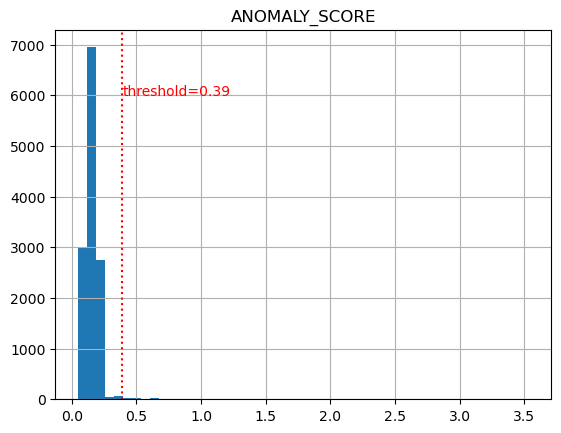

3 sigma threshoud = 0.38911766538723647


In [43]:
threshold_re = pdScores['ANOMALY_SCORE'].mean() + 2.5*pdScores['ANOMALY_SCORE'].std()

pdPlot = pd.DataFrame(pdScores['ANOMALY_SCORE'])
pdPlot.hist(bins=50)
plt.axvline(x=threshold_re, linestyle=':', c='r')
plt.annotate('threshold={}'.format(round(threshold_re,2)), xy=(threshold_re,6000), color='r')
plt.show()

print('3 sigma threshoud = {}'.format(threshold_re))

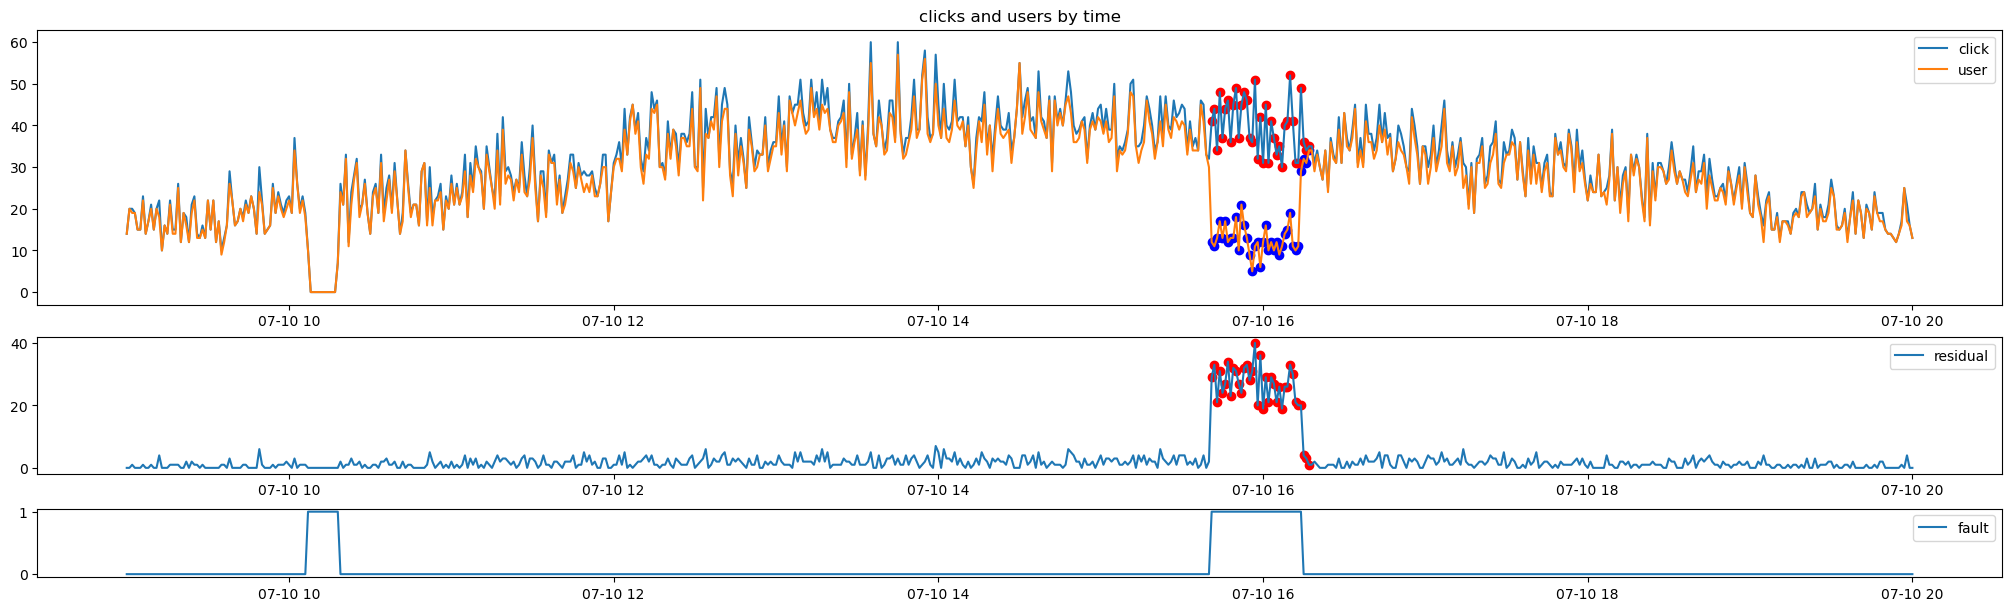

In [44]:
anomalous = pdScores.query("ANOMALY_SCORE > @threshold_re")
stime = "2020-07-10 09:00:00" # "2012-03-13 08:00:00"
etime = "2020-07-10 20:00:00" # "2012-03-13 20:00:00"
plot_click_w_fault_res_ad(pdScores, anomalous, threshold_re, start_dt=stime, end_dt=etime)

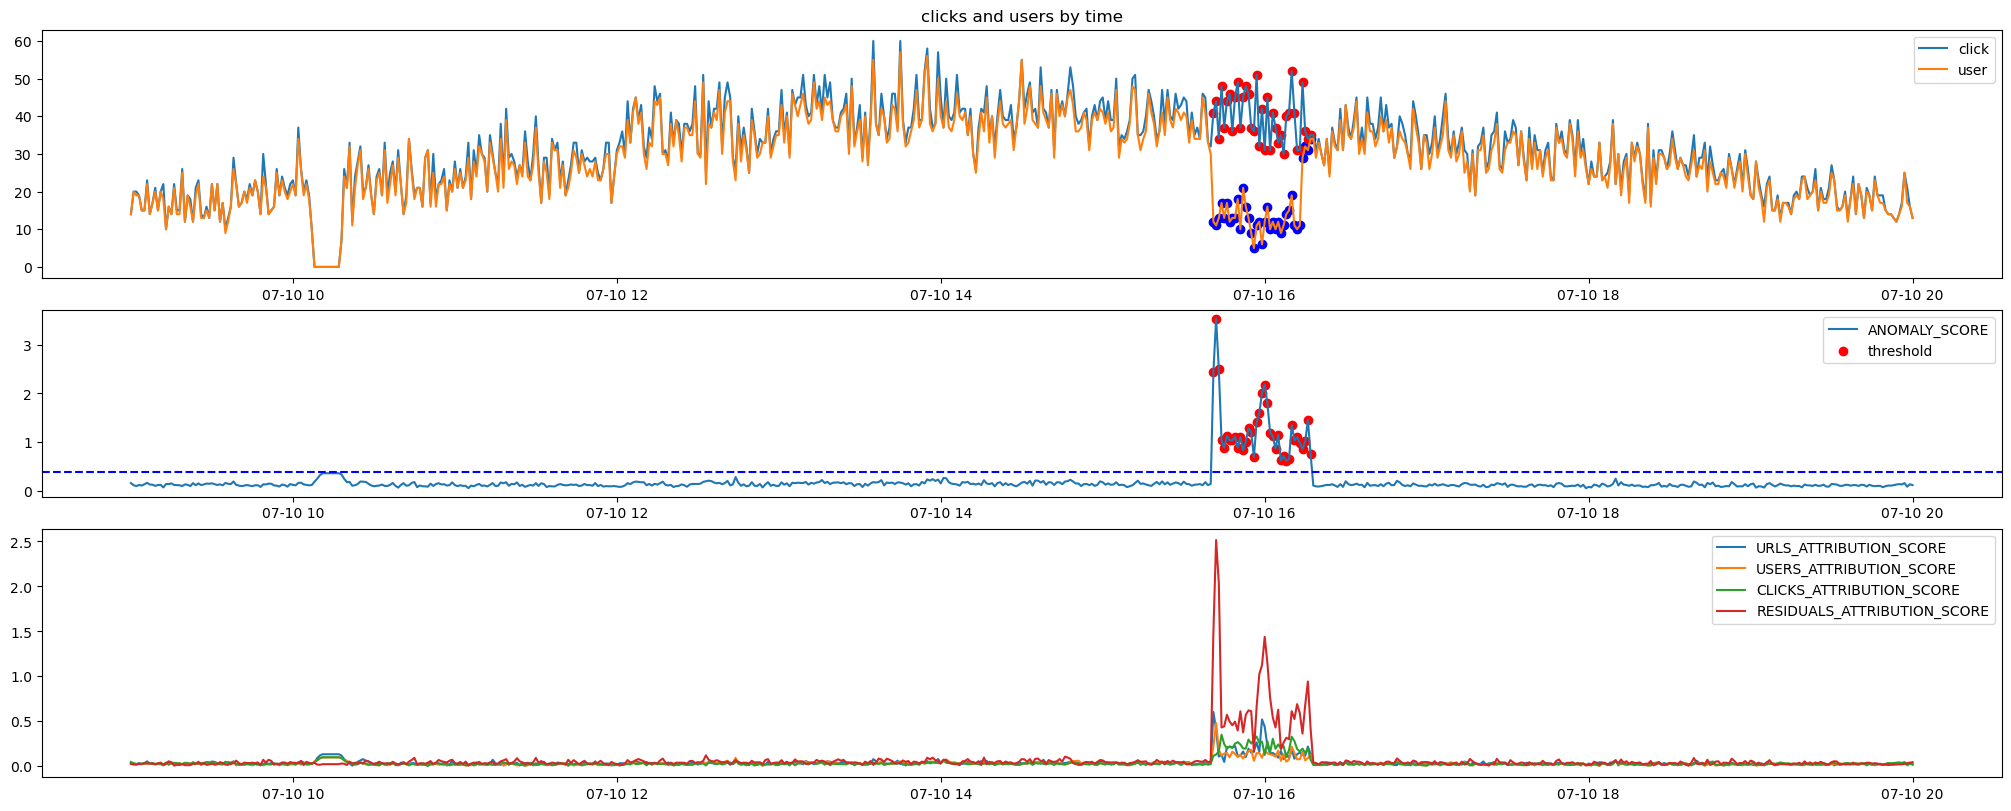

In [45]:
plot_click_w_ad_exp(pdScores, anomalous, threshold_re, start_dt=stime, end_dt=etime)

In [48]:
pdAnomal = pdScores.query("ANOMALY_SCORE > @threshold_re")[["ANOMALY_SCORE", "URLS_ATTRIBUTION_SCORE", "USERS_ATTRIBUTION_SCORE", \
                                                         "CLICKS_ATTRIBUTION_SCORE", "RESIDUALS_ATTRIBUTION_SCORE", "ANOMALY_SCORE_SAP"]] 

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


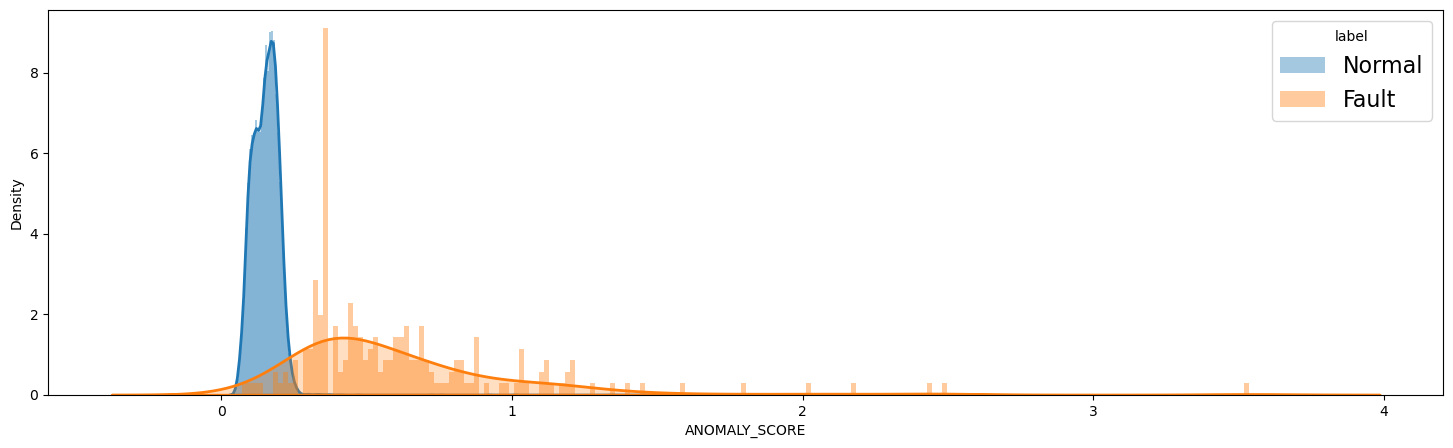

In [49]:
plt.figure(figsize = (18,5))
fault_types = [0, 1]
for fault_type in fault_types:
    
    if fault_type == 0: label = "Normal"
    else: label = "Fault"
    sns.distplot(
        pdScores[pdScores.fault==fault_type]["ANOMALY_SCORE"],
        hist=True,
        kde=True,
        kde_kws={"shade":True, "linewidth":2},
        label=label,
        bins=200
    )
plt.legend(prop={"size":16}, title = "label")

* performance metric

In [50]:
precision = pdScores.query("fault == 1 and ANOMALY_SCORE > @threshold_re").shape[0] / pdScores.query("ANOMALY_SCORE > @threshold_re").shape[0]
recall = pdScores.query("fault == 1 and ANOMALY_SCORE > @threshold_re").shape[0] / pdScores.query("fault == 1").shape[0]
f1_score = 2*(precision*recall)/(precision+recall)

In [51]:
print (f'Precision: {precision}')
print (f'Recall: {recall}')
print (f'f1_score: {f1_score}')

Precision: 0.9361702127659575
Recall: 0.6502463054187192
f1_score: 0.7674418604651162


###  - For SAP Score

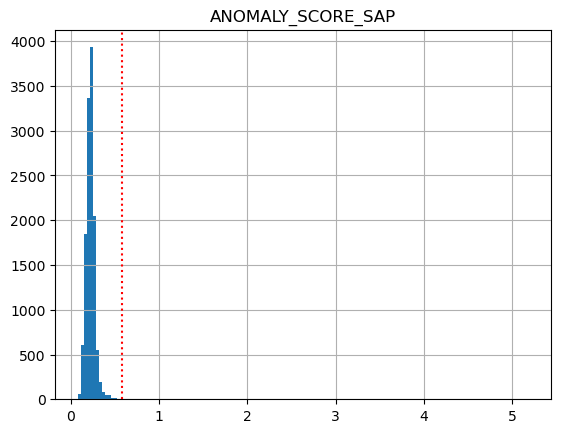

3 sigma threshoud = 0.5817722156643867


In [52]:
threshold_sap = pdScores['ANOMALY_SCORE_SAP'].mean() + 2.5*pdScores['ANOMALY_SCORE_SAP'].std()

pdPlot = pd.DataFrame(pdScores['ANOMALY_SCORE_SAP'])
pdPlot.hist(bins=150)
plt.axvline(x=threshold_sap, linestyle=':', c='r')
plt.annotate('threshold={}'.format(round(threshold_sap,2)), xy=(threshold_sap,6000), color='r')
plt.show()

print('3 sigma threshoud = {}'.format(threshold_sap))

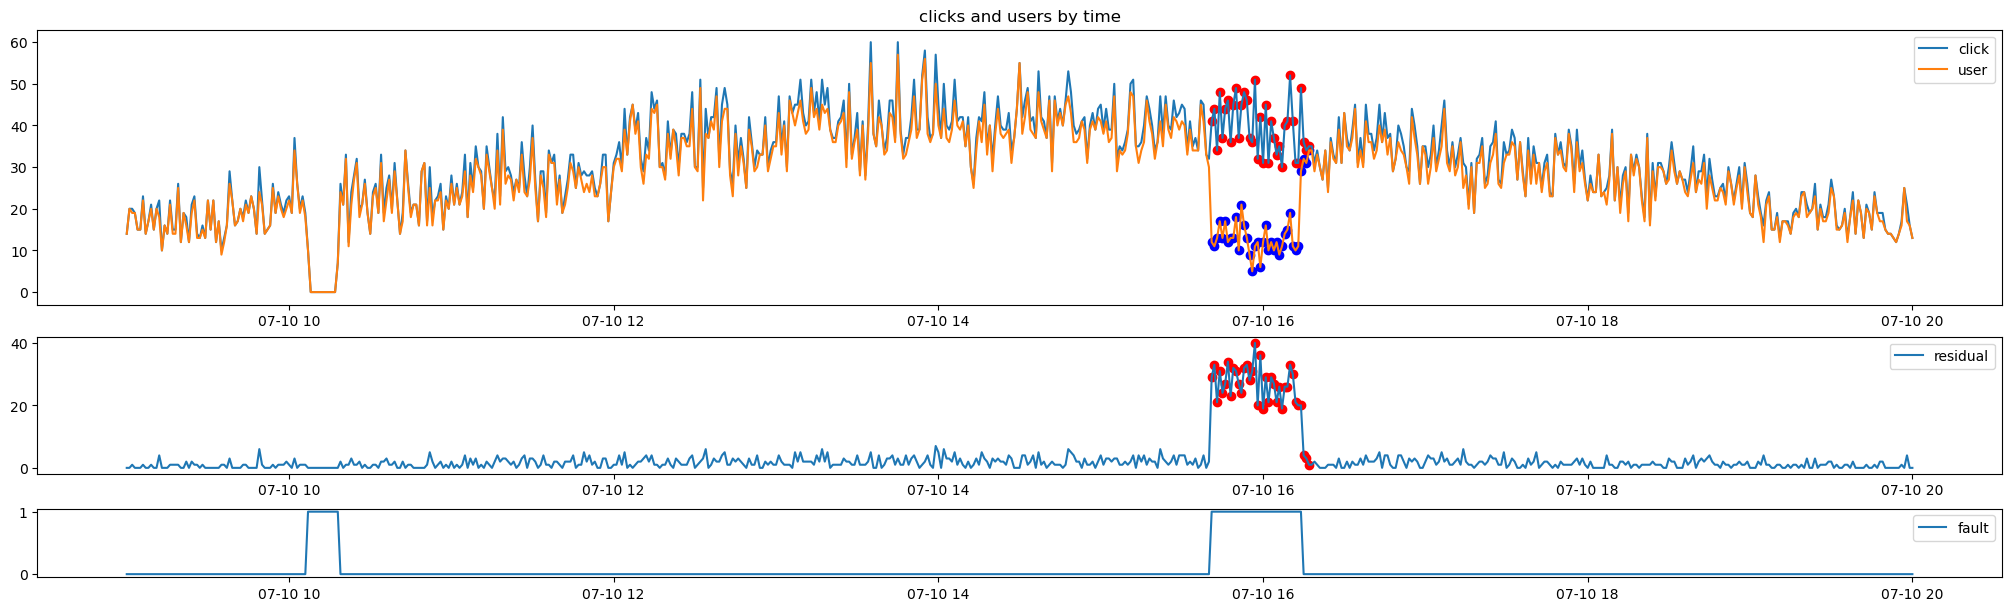

In [53]:
anomalous = pdScores.query("ANOMALY_SCORE_SAP > @threshold_sap")
stime = "2020-07-10 09:00:00" # "2012-03-13 08:00:00"
etime = "2020-07-10 20:00:00" # "2012-03-13 20:00:00"
plot_click_w_fault_res_ad(pdScores, anomalous, threshold_sap, start_dt=stime, end_dt=etime)

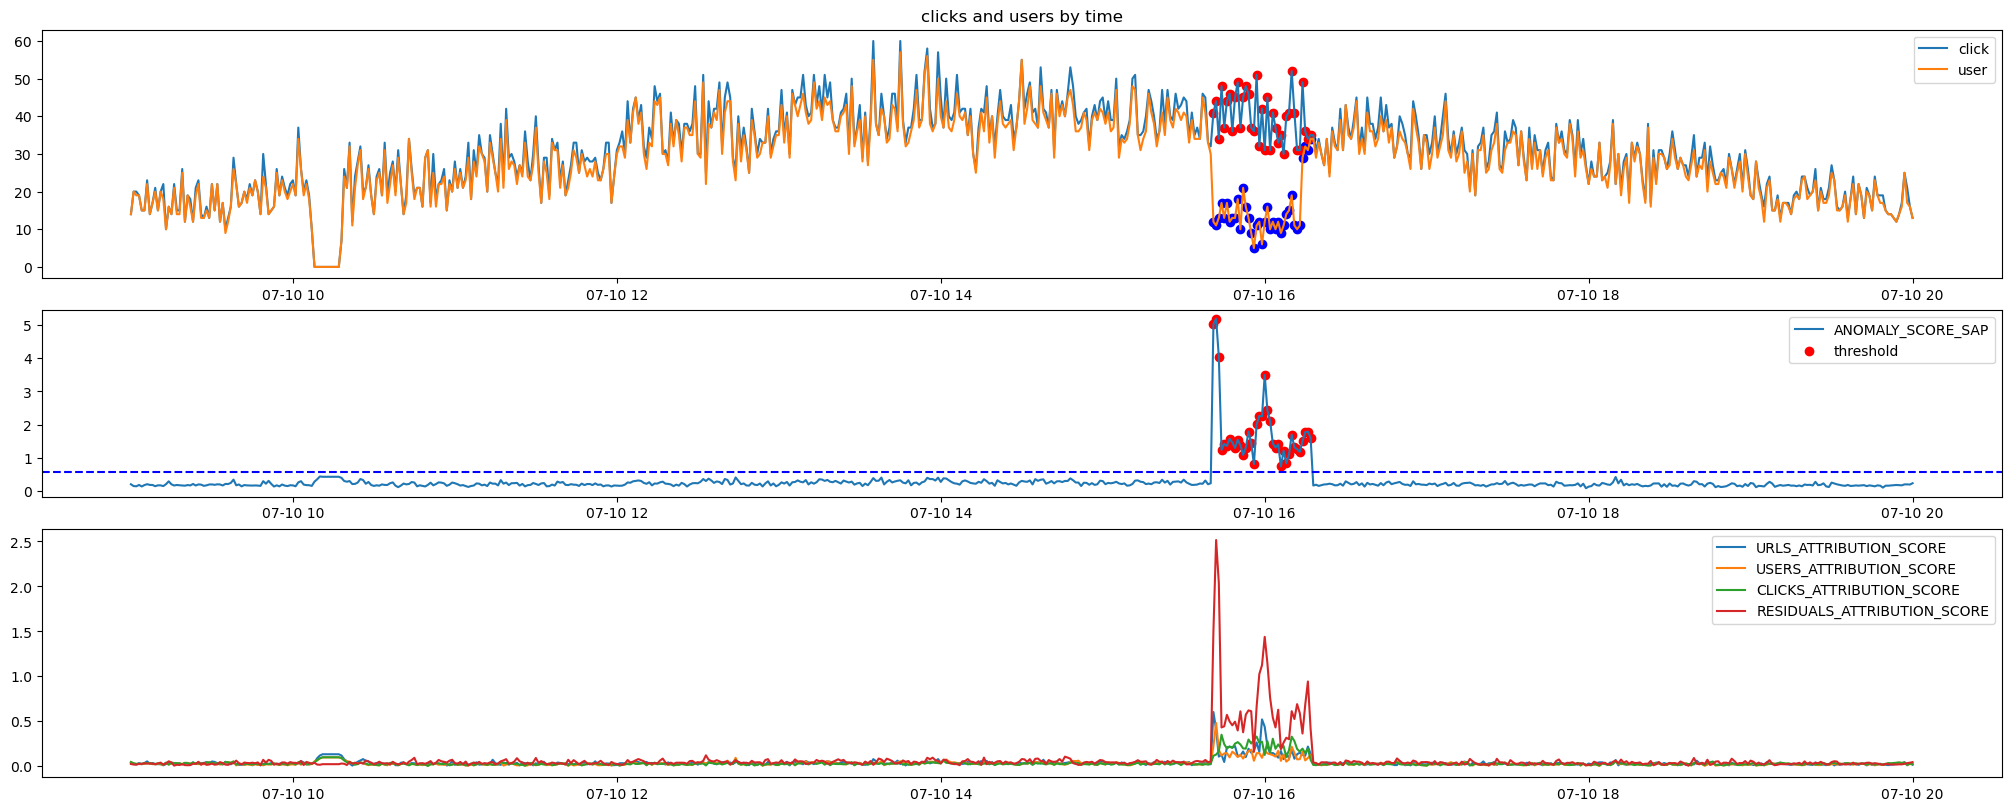

In [54]:
plot_click_w_ad_exp(pdScores, anomalous, threshold_sap, start_dt=stime, end_dt=etime, score="ANOMALY_SCORE_SAP")

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


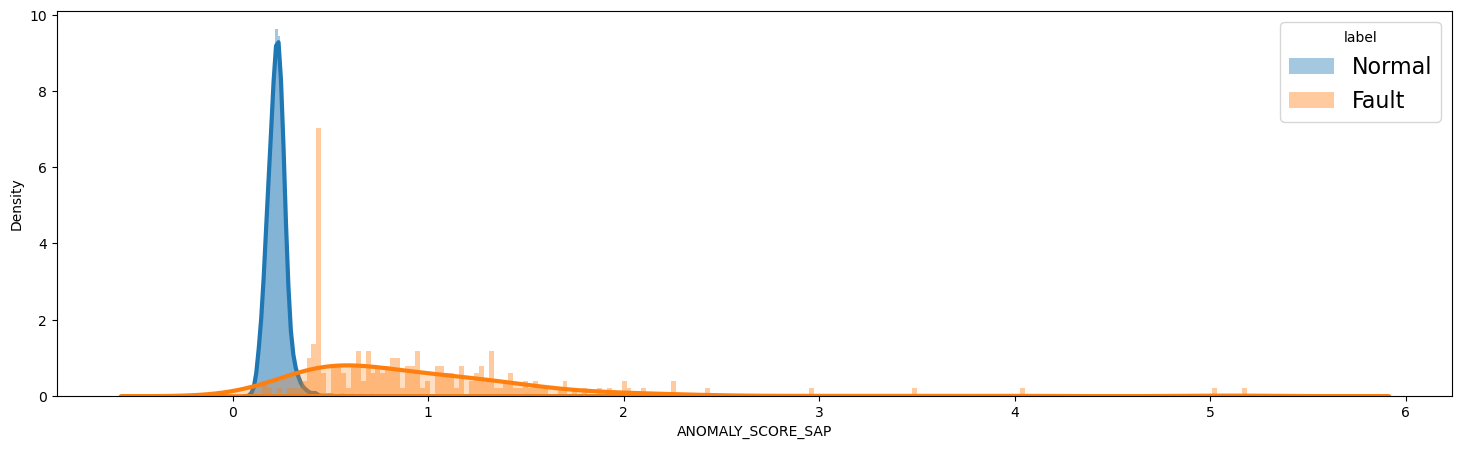

In [55]:
plt.figure(figsize = (18,5))
fault_types = [0, 1]
for fault_type in fault_types:
    
    if fault_type == 0: label = "Normal"
    else: label = "Fault"
    sns.distplot(
        pdScores[pdScores.fault==fault_type]["ANOMALY_SCORE_SAP"],
        hist=True,
        kde=True,
        kde_kws={"shade":True, "linewidth":3},
        label=label,
        bins=200
    )
plt.legend(prop={"size":16}, title = "label")

In [56]:
precision = pdScores.query("fault == 1 and ANOMALY_SCORE_SAP > @threshold_sap").shape[0] / pdScores.query("ANOMALY_SCORE_SAP > @threshold_sap").shape[0]
recall = pdScores.query("fault == 1 and ANOMALY_SCORE_SAP > @threshold_sap").shape[0] / pdScores.query("fault == 1").shape[0]
f1_score = 2*(precision*recall)/(precision+recall)

In [57]:
print (f'Precision: {precision}')
print (f'Recall: {recall}')
print (f'f1_score: {f1_score}')

Precision: 0.8979591836734694
Recall: 0.6502463054187192
f1_score: 0.7542857142857142
